# **Project Tumor Trace: MRI-Based AI for Breast Cancer Detection**

# Business Understanding

- **Objective :** Build a machine learning model to classify breast cancer status (benign or malignant) using MRI images.
- **Project Goals :** Aid in the early detection of breast cancer to improve patient outcomes.
- **Problem Statement :** 

> - Breast cancer is a major cause of death among women worldwide.
> - Early detection plays a vital role in improving survival rates.
> - Manual analysis of MRI scans is slow, expensive, and prone to errors.
  </ul>
</p>  </ul>
</p>.


# Data Understanding

## Loading the Dataset

In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2
from torch.utils.data import DataLoader, WeightedRandomSampler

# Define the path to your dataset
data_dir = r"/kaggle/input/tumor-trace-dataset"

# Check the directory structure
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the classes available in the train directory
print("Classes in training set:")
print(os.listdir(train_dir))

print("\nClasses in val set:")
print(os.listdir(val_dir))

print("\nClasses in test set:")
print(os.listdir(test_dir))

Classes in training set:
['Benign', 'Malignant']

Classes in val set:
['Benign', 'Malignant']

Classes in test set:
['Benign', 'Malignant']


## Anaylzing the dataset

### Counting images in each class directory

In [ ]:
import matplotlib.pyplot as plt 
from PIL import Image

def count_images(directory):
   
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in the training set
train_class_counts = count_images(train_dir)
print("Number of images in each class (train):", train_class_counts)


Number of images in each class (train): {'Benign': 61, 'Malignant': 105}


### Displaying sample images from a given directory

Sample images from the 'Benign' class


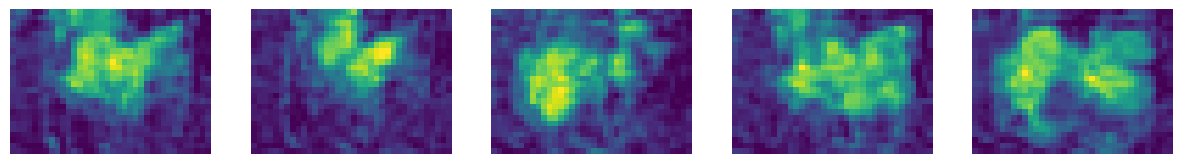

Sample images from the 'Malignant' class


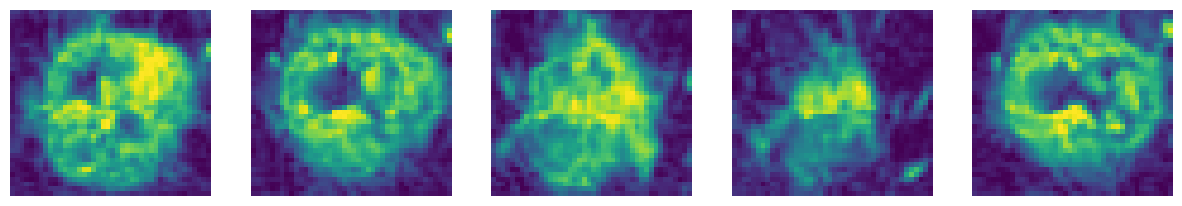

In [18]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Displayingg sample images from a given directory
def show_sample_images(class_dir, num_images=5):
    
    class_images = os.listdir(class_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(class_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


# Defining the train\Benign\BreaDM-Be-1801 directory 
benign_images = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801"
img_dir = os.path.join(benign_images, 'SUB1')

malignant_images = r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1802"
img_dir = os.path.join(benign_images, 'SUB2')

# Showing sample images from the 'Benign' class
print("Sample images from the 'Benign' class")
show_sample_images(os.path.join(benign_images, 'SUB1'))


# Showing sample images from the 'Maligant' class
print("Sample images from the 'Malignant' class")
show_sample_images(os.path.join(malignant_images, 'SUB2'))




# Data Preparation


## Data Transformation

In [19]:
import torchvision.transforms as transforms
import torch

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224 pixels
    transforms.ToTensor(),  # Converting to PyTorch tensor
    # Normalization- process of scaling pixel intensity values to a common range
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])


### Visualizing the transform Image

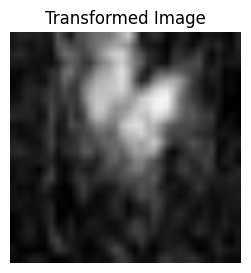

In [20]:
# Function to visualize the transformed image
def show_transformed_image(img_path):
    # Open the image
    image = Image.open(img_path)

    # Convert the image to RGB if it’s in a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Apply the transformations
    transformed_image = transform(image)
    
    # Convert back to numpy for visualization
    img = transformed_image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    
    # Unnormalize the image for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Clamp the values to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()

# Example image 
example_image_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
show_transformed_image(example_image_path)

### Data Augmentation

In [21]:
# Define data augmentation with additional techniques
train_transform = transforms.Compose([
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomGrayscale(p=0.3),  # Increased grayscale probability
    transforms.RandomAffine(degrees=15),  # Slight affine transformations for rotation/translation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [22]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Visualizing the Augmentated image

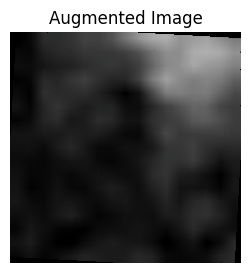

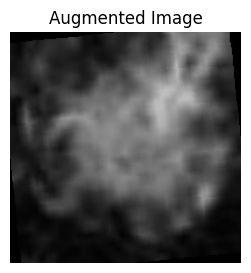

In [23]:
# Function to visualize the augmented image
def show_augmented_image(img_path):
    # Open the image
    image = Image.open(img_path)

    # Converting the image to RGB if it’s in a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Applying the augmentation transformations
    augmented_image = train_transform(image)

    # Convert back to numpy for visualization
    img = augmented_image.permute(1, 2, 0)  # Change from (Channels, Height, Width) to (Height, Width, Channels)

    # Unnormalize the image for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Clamp the values to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()

# Example image paths for Benign and Malignant classes
benign_example_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
malignant_example_path = r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1802/SUB2/p-035.jpg"

# Show augmented images
show_augmented_image(benign_example_path)
show_augmented_image(malignant_example_path)

## Setting up Dataloaders

### Creating Dataset with updated transformation

In [24]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

data_dir = "/kaggle/input/tumor-trace-dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)

### Creating DataLoader

In [25]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# Check the size of each dataset
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 20434
Validation set size: 1989
Test set size: 6851


### Example of Data transformation on single image

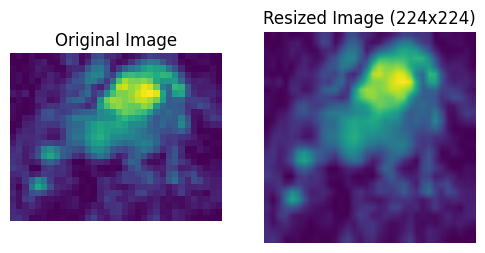

In [26]:
# Definingg the path to your image
img_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1805/SUB2/p-033.jpg" 

# Load the image
image = Image.open(img_path)

# Defining the transformation
resize_transform = transforms.Resize((224, 224))

# Apply the transformation
resized_image = resize_transform(image)

# Visualizingg the original and resized images
plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resized Image (224x224)')
plt.imshow(resized_image)
plt.axis('off')

plt.show() 

# Feature Extraction technique

## Histogram of Oriented Gradients (HOG)

- HOG is a feature descriptor in computer vision that is widely used for object detection.

- captures appearance and shape information of an object by counting the occurrences of gradient orientations in localized regions of an image.

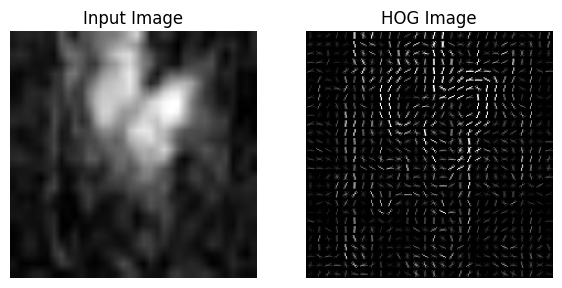

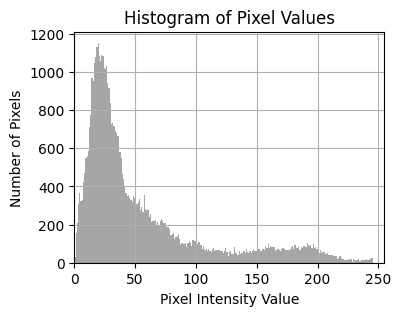

In [27]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Load the image
image_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resizing the image to 224x224
resized_image = cv2.resize(image, (224, 224))

hog_features, hog_image = hog(
    resized_image, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    visualize=True, 
    feature_vector=True, 
    block_norm='L2-Hys'
)
pixel_values = resized_image.flatten()

# Rescaling histogram 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display the HOG image
plt.figure(figsize=(7, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Input Image')
plt.imshow(resized_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('HOG Image')
plt.imshow(hog_image_rescaled, cmap='gray')

plt.figure(figsize=(4, 3))
plt.hist(pixel_values, bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Number of Pixels')
plt.xlim(0, 255)  # For 8-bit grayscale images
plt.grid()


plt.show()


## Sobel Operator
- Operator is used to find the edges in an image by specifying regions where there is a significant change in intensity (brightness).
- It works by calculating the gradient (rate of change) of the image intensity at each pixel.


In [28]:
import numpy as np

# 3x3 matrix representing a simple image.
image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# 2x2 matrix used for convolution,helpingg to detect patterns in the image.
kernel = np.array([
    [1, 0],
    [0, -1]
])

# Function to perform convolution on the input image with the given kernel.
def convolve(image, kernel):
    image_x, image_y = image.shape # dimensions (height and width) of the image.
    kernel_x, kernel_y = kernel.shape # dimensions of the kernel

    # Kernel radius
    height_radius, width_radius = np.array(kernel.shape) // 2
    
    # Determine the output dimensions
    stride = 1
    padding = 0
    output_x = int(((image_x - kernel_x + 2 * padding) // stride) + 1) 
    output_y = int(((image_y - kernel_y + 2 * padding) // stride) + 1)
    print("\nOutput x dimension:", output_x)
    print("Output y dimension:", output_y)
    
    # Initialize the output feature map
    output = np.zeros((output_x, output_y))
    
    # Perform convolution
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Perform convolution
convolved_image = convolve(image, kernel)
print("\nConvolved Image:\n", convolved_image)

# Eg Sobel X operator detecting horizontal edges.
Sobel_x_operator = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Perform convolution with Sobel operator
sobel_convolved_image = convolve(image, Sobel_x_operator)
print("\nSobel X Convolved Image:\n", sobel_convolved_image)



Output x dimension: 2
Output y dimension: 2

Convolved Image:
 [[-4. -4.]
 [-4. -4.]]

Output x dimension: 1
Output y dimension: 1

Sobel X Convolved Image:
 [[8.]]


[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


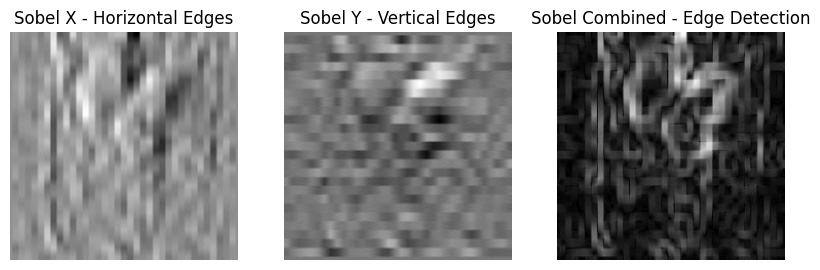

In [29]:
 import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to perform convolution
def convolve(image, kernel):
    image_x, image_y = image.shape   # dimensions (height and width) of the image.
    kernel_x, kernel_y = kernel.shape # dimensions of the kernel
    print(kernel)

    # Determining the output dimensions
    stride = 1 # step size by which we move the kernel across the image (set to 1 here).
    padding = 0
    output_x = int(((image_x - kernel_x + 2 * padding) // stride) + 1) # dimensions of the output image after applying the kernel. #1
    output_y = int(((image_y - kernel_y + 2 * padding) // stride) + 1) # dimensions of the output image after applying the kernel.#1
    
    # Initialize the output feature map
    output = np.zeros((output_x, output_y)) # matrix initialized to zeros to store the convolution result.
    #initialized to zeros to ensure it starts with a clean slate.

    # Perform convolution in that we  move the kernel over the image.
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]
            output[i, j] = np.sum(region * kernel)

    return output

# Sobel X operator (horizontal edges)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Sobel Y operator (vertical edges)
sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

# Load the image and convert to grayscale
image = resized_image

image = np.array(image)
# Converting the Image to a Numpy Array:

# Apply Sobel X operator
sobel_x_image = convolve(image, sobel_x)

# Apply Sobel Y operator
sobel_y_image = convolve(image, sobel_y)

# Calculate the magnitude of gradients
sobel_combined = np.sqrt(sobel_x_image**2 + sobel_y_image**2)

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sobel_x_image, cmap='gray')
plt.title('Sobel X - Horizontal Edges')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_y_image, cmap='gray')
plt.title('Sobel Y - Vertical Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Combined - Edge Detection')
plt.axis('off')

plt.show()


## Local Binary Pattern
Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.


- 1. Divide image into cells: For each pixel in a cell, compare it with its neighbors.
- 2. Threshold the neighborss: If the neighbor's value is greater than or equal to center pixel's value, set it to 1; otherwise, set it to 0.
- 3. Generate a binary number: Concatenate all the binary values (0s and 1s) to form a binary number.
- 4. Convert to decimal: Convert the binary number to a decimal value.
- 5. Replace the pixel value: The center pixel is replaced with the decimal value.

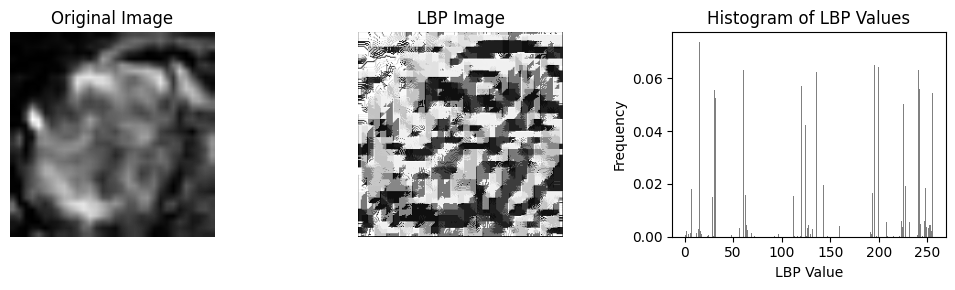

Each element in this array represents the brightness of a pixel, with values typically ranging from 0 (black) to 255 (white).


In [30]:
# Using Library

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern


def edge_detection(img_path):

    # Load the image in the greyscale modeee
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resizing the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Apply LBP
    radius = 1  # radius of 1 means that the neighbors are directly adjacent to the center pixel.

    n_points = (8 * radius)  # 8 * radius because in a unit circle (radius 1), there are 8 discrete sampling points.

    lbp_image = local_binary_pattern(image, n_points, radius, method="default")

    """Example: 'default'
    
'default': Regular LBP, where each bit of the binary pattern is a direct thresholding result.
'uniform': LBP where patterns with at most two 0-1 or 1-0 transitions are considered uniform. This results in a smaller feature set.
'ror': Rotation-invariant patterns achieved by bitwise rotation.
'var': Rotation-invariant variance measures of the LBP codes.
Purpose: Specifies how to handle the binary patterns, allowing for different levels of robustness and feature reduction."""

    # grid of 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    # Original Image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # LBP Image
    ax[1].imshow(lbp_image, cmap="gray")
    ax[1].set_title("LBP Image")
    ax[1].axis("off")

    # Histogram of LBP Values
    n_bins = int(lbp_image.max() + 1)
    ax[2].hist(
        lbp_image.ravel(), bins=n_bins, range=(0, n_bins), density=True, color="gray"
    )
    ax[2].set_title("Histogram of LBP Values")
    ax[2].set_xlabel("LBP Value")
    ax[2].set_ylabel("Frequency")

    # Display the combined visuals
    plt.tight_layout()
    plt.show()


# Example usage
example_img_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1806/SUB2/p-024.jpg"
edge_detection(example_img_path)
print(
    "Each element in this array represents the brightness of a pixel, with values typically ranging from 0 (black) to 255 (white)."
)


## MVM-LBP -  Mean-Variance-Median Local Binary Pattern
- It’s an advanced method for texture description and face recognition.
- Instead of comparing each neighbor to just the center pixel, we compare each neighbor to a threshold that combines the mean, variance, and median of the pixels in the 3x3 window.

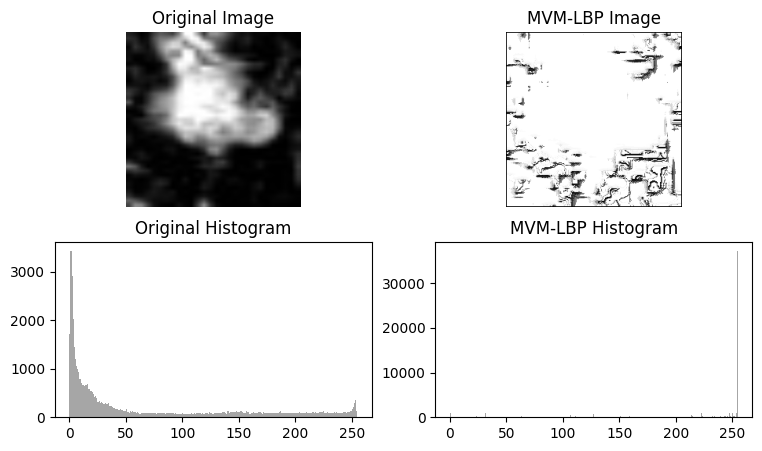

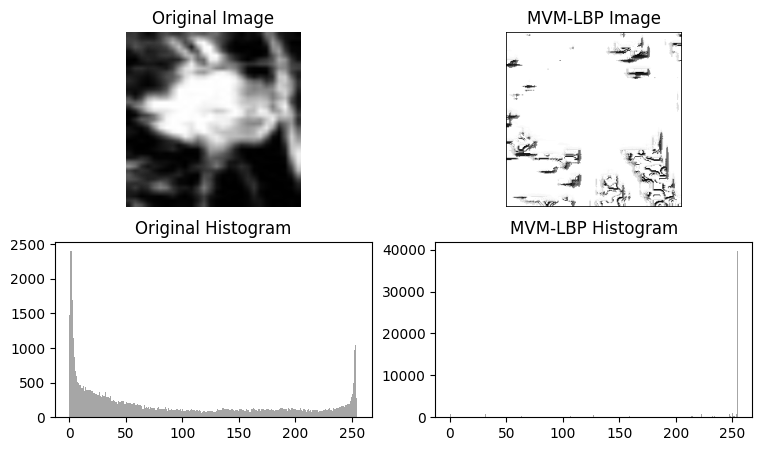

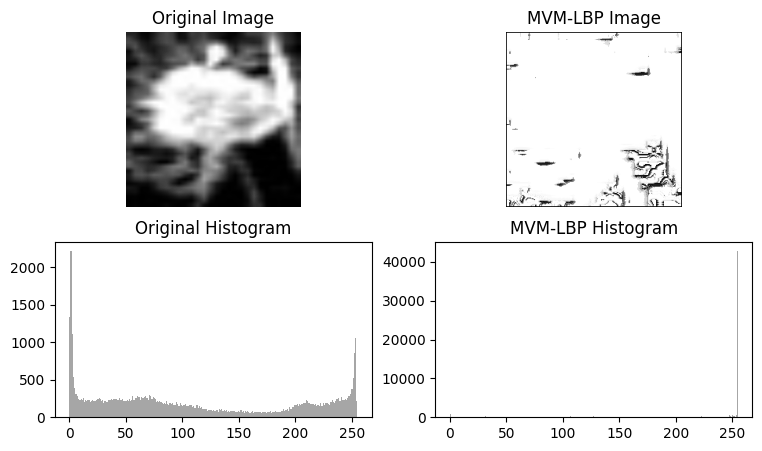

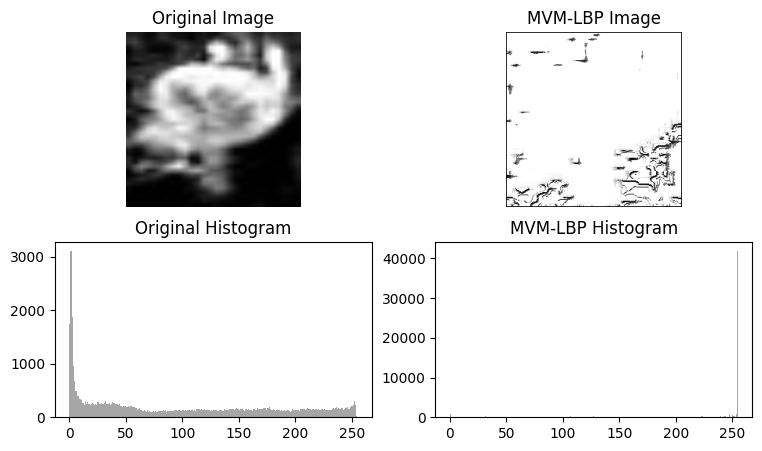

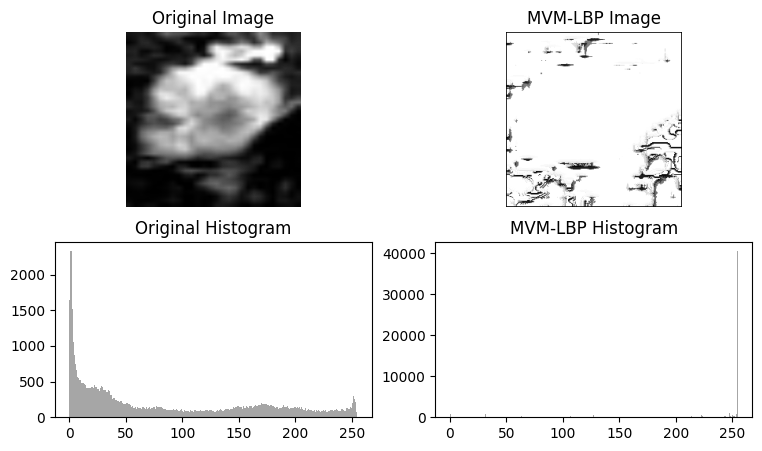

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean-Variance-Median Local Binary Pattern (MVM-LBP)
def calculate_mvm_lbp(image):
    rows, cols = image.shape  # Get dimensions of the image
    mvm_lbp_image = np.zeros((rows, cols), dtype=np.uint8)  # Initializingg an empty image for MVM-LBP

    for i in range(1, rows - 1):  # Loop over each pixel, excluding the border
        for j in range(1, cols - 1):
            # 3x3 window around the center pixel
            window = image[i - 1:i + 2, j - 1:j + 2]

            #  mean, variance, and median of the 3x3 window
            mean = np.mean(window)
            variance = np.var(window)
            median = np.median(window)

            # threshold =  average of mean, square root of variance, and median
            threshold = (mean + np.sqrt(variance) + median) / 3

            # 8-bit binary pattern based on the threshold
            binary_str = ''.join(['1' if window[x, y] >= threshold else '0'
                                  for x in range(3) for y in range(3) if (x, y) != (1, 1)])  # no center value is counting
            # Convert binary string to integer and set it as the new pixel value
            mvm_lbp_image[i, j] = int(binary_str, 2)

    return mvm_lbp_image

# Function to plot original and MVM-LBP images with their histograms
def plot_images_and_histograms(original, mvm_lbp_image):
    fig, ax = plt.subplots(2, 2, figsize=(9, 5))

    # Plot original image
    ax[0, 0].imshow(original, cmap='gray')
    ax[0, 0].set_title('Original Image')
    ax[0, 0].axis('off')

    # Plot MVM-LBP image
    ax[0, 1].imshow(mvm_lbp_image, cmap='gray')
    ax[0, 1].set_title('MVM-LBP Image')
    ax[0, 1].axis('off')

    # Plot histograms
    ax[1, 0].hist(original.ravel(), bins=256, color='gray', alpha=0.7)
    ax[1, 0].set_title('Original Histogram')

    ax[1, 1].hist(mvm_lbp_image.ravel(), bins=256, color='gray', alpha=0.7)
    ax[1, 1].set_title('MVM-LBP Histogram')

    plt.show()

# five images
img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]

# Process each image path
for img_path in img_paths:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  #image in grayscale
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue
    image = cv2.resize(image, (224, 224))
    # MVM-LBP
    mvm_lbp_image = calculate_mvm_lbp(image)

    # original and MVM-LBP images with histograms
    plot_images_and_histograms(image, mvm_lbp_image)


## LBP- Mean
- LBP Mean refers to a variation of the Local Binary Pattern (LBP) method, where the mean value of pixel intensities is calculated for the local neighborhood around a central pixel.
- This mean value is then used to characterize the texture of the image.
- It helps in capturing the average intensity distribution, which is useful for texture classification and image analysis tasks.

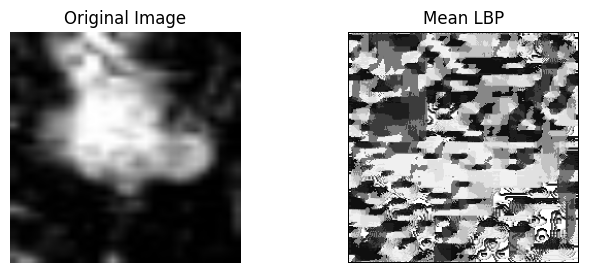

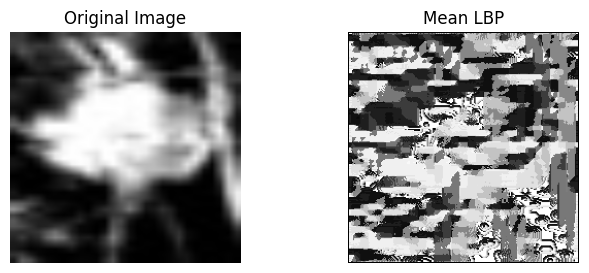

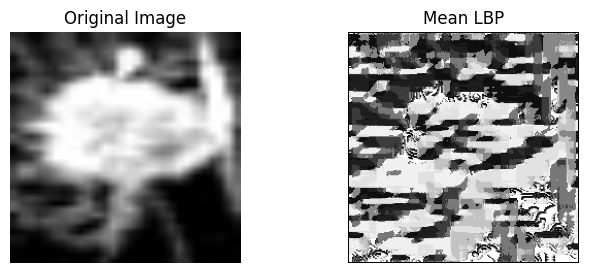

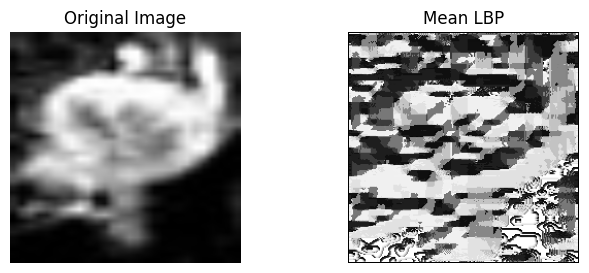

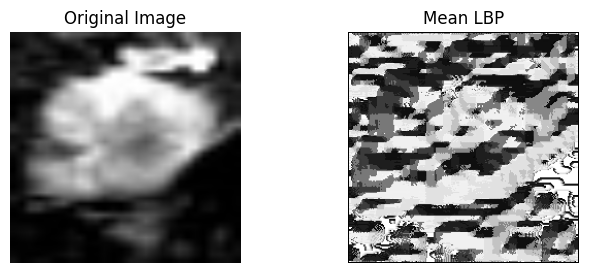

In [32]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]

#Function for median

def mean_lbp(image): 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    mean_lbp_image = np.zeros((rows, cols), dtype=np.uint8)


    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_mean = np.mean(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_mean else '0' for pixel in neighborhood])
            mean_lbp_image[i, j] = int(binary_str, 2)
    
    return mean_lbp_image        


for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    mean_lbp_image = mean_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mean_lbp_image, cmap='gray')
    ax[1].set_title('Mean LBP')
    ax[1].axis('off')

    plt.show()



## LBP - Median

- LBP Median refers to a variant of Local Binary Pattern (LBP) that uses the median value of the pixel intensities in the local neighborhood around each central pixel, instead of comparing them to the center pixel's intensity.
- The median value is more robust to noise, as it represents the middle value in a sorted list of neighboring intensities.
- This approach helps in capturing texture patterns while minimizing the impact of outliers or noise

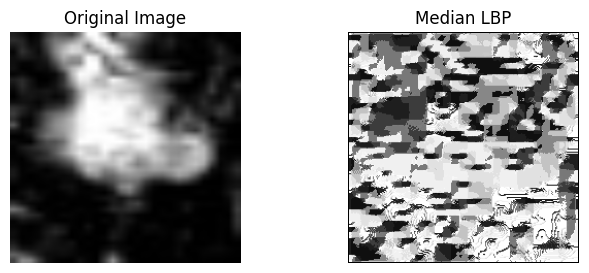

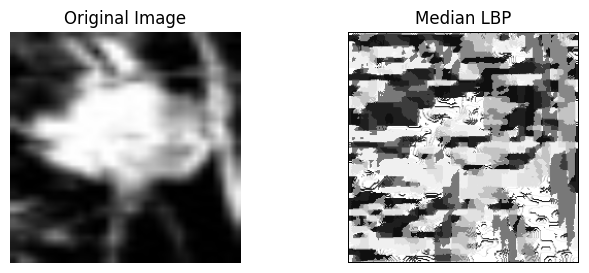

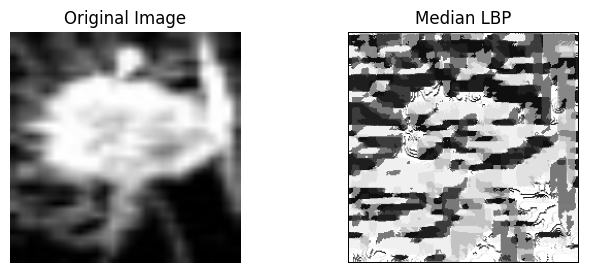

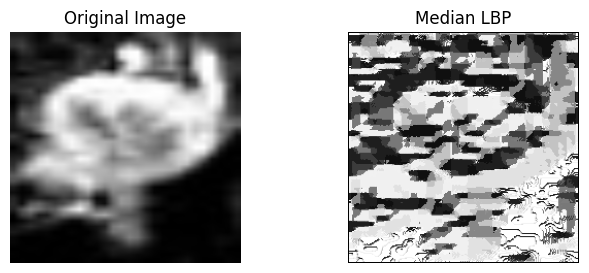

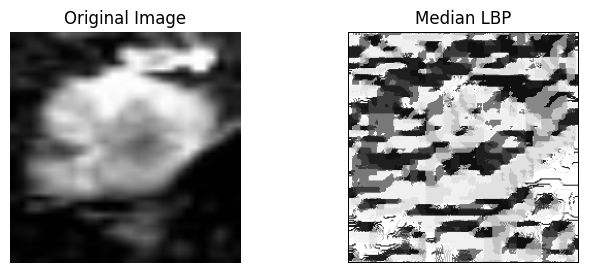

In [33]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]


# Function for Median LBP
def median_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    median_lbp_image = np.zeros((rows, cols), dtype=np.uint8)
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_median = np.median(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_median else '0' for pixel in neighborhood])
            median_lbp_image[i, j] = int(binary_str, 2)
    
    return median_lbp_image


for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    median_lbp_image = median_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(median_lbp_image, cmap='gray')
    ax[1].set_title('Median LBP')
    ax[1].axis('off')

    plt.show()



## LBP- Variance
Variance = Average of the squared differences from the Mean
- LBP Variance refers to a variant of the Local Binary Pattern (LBP) technique, which captures the variation in pixel intensity patterns around a central pixel in an image.
- It measures the statistical dispersion (variance) of the binary patterns in a local region, helping to characterize texture by quantifying how much the pixel intensities deviate from the mean.
- This feature is useful for texture classification tasks.

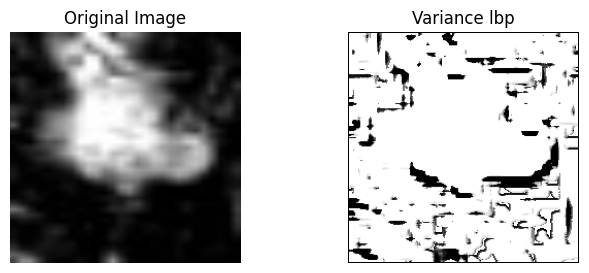

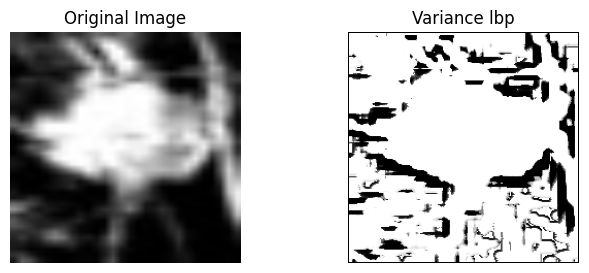

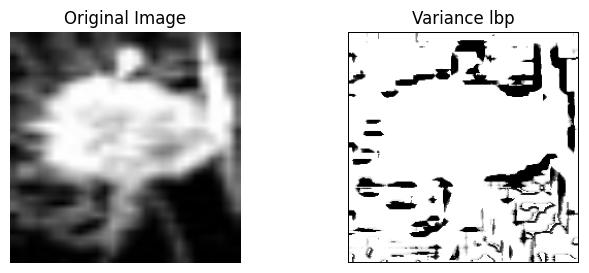

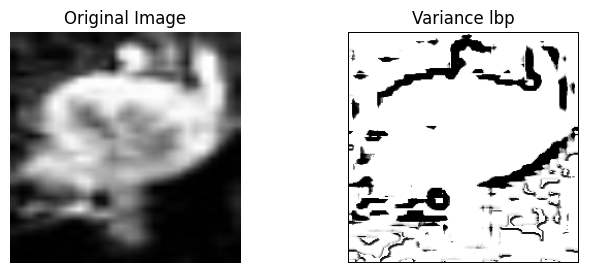

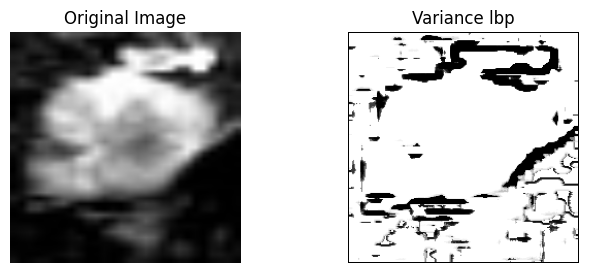

In [34]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"

]

# FUNCTION for the variance 
def variance_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    variance_lbp_image = np.zeros((rows, cols), dtype=np.uint8)
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_variance = np.var(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_variance else '0' for pixel in neighborhood])
            variance_lbp_image[i, j] = int(binary_str, 2)
    
    return variance_lbp_image
    

for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    var_lbp_image = variance_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow( var_lbp_image, cmap='gray')
    ax[1].set_title('Variance lbp')
    ax[1].axis('off')

    plt.show()



## GLCM (Gray-Level Co-occurrence Matrix)
count the occurrences of each pair of pixel values.

In [35]:
import numpy as np

# 4x4 image
image = np.array([
    [0, 1, 1, 2],
    [2, 2, 1, 0],
    [1, 0, 0, 2],
    [3, 2, 2, 3]
])

#  GLCM matrix size based on the pixel values range
max_value = image.max()
print(max_value)
glcm = np.zeros((max_value + 1, max_value + 1), dtype=int)

# comparing each pixel with its right neighborr
rows, cols = image.shape
print(image.shape)
for row in range(rows): # The outer loop iterates over each row of the image.
    for col in range(cols - 1):  #The inner loop iterates over each column of the image & Exclude the last column to avoid out-of-bound error
        current_pixel = image[row, col]
        neighbor_pixel = image[row, col + 1]
        glcm[current_pixel, neighbor_pixel] += 1

# Print the resulting GLCM matrix
print("GLCM Matrix:")
print(glcm)


3
(4, 4)
GLCM Matrix:
[[1 1 1 0]
 [2 1 1 0]
 [0 1 2 1]
 [0 0 1 0]]


### Early Stopping
- Early stopping is a form of regularization used to prevent overfitting in machine learning and deep learning models.
- It involves stopping the training process before the model starts to overfit.
- The idea is to monitor the model’s performance on a validation set during the training process and stop training when the performance starts to degrade


In [36]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience # How long to wait after last time validation loss improved.
        self.verbose = verbose #If true, prints a message for each validation loss improvement. 
        self.delta = delta # Minimum change in monotered quality to quantofy improvement
        self.path = path # file path for saving the model checkpoint
        self.trace_func = trace_func # fun to output message
        self.counter = 0 # track of epochs with no improvement.
        self.best_score = None #store the best score
        self.early_stop = False #indicating whether to stop training.
        self.val_loss_min = np.Inf # store the minimum validation loss encountered during training
        #self.best_epoch = 0 #The epoch number of the best model.
        #Epoch is used to describe one complete pass through the entire training dataset.


    def __call__(self, val_loss, model):
        # method is called at end of each epoch to check if the validation loss has improved.
        score = -val_loss

        if self.best_score is None:
            self.best_score = score #the current score is set as the best score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

# checkpoint methond
    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). save model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Models Development

## Setting up the Vgg16 Model

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models

model_name = 'vgg16'
#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nm.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

# printing model
if __name__ == "__main__":
    model = CustomVGG16(num_classes=2)
    print(model)
    



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s] 


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [38]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

## Ploting Functions

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5))
    #cmap = sns.color_palette(["#7469B6","#D7B26D" ,"#AD88C6", "#E1AFD1", "#FFE6E6"], as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_auc(fpr, tpr, auc_score):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='#D20062', lw=2, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='#D1BB9E', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Class Weights

In [61]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extracting labels from the training dataset
train_labels = [label for _, label in train_dataset.samples]

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# loss function to include class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# weighted sampler to handle class imbalance
class_sample_counts = np.bincount(train_labels)
weights = 1. / class_sample_counts
samples_weights = weights[train_labels]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

#DataLoader with the sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, drop_last=True)

## Train Function

In [48]:
import torch
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tqdm import tqdm

def train(epoch, model, num_epochs, loader, criterion, optimizer, device):
    model.train()
    correct = 0
    total_loss = 0
    scaler = GradScaler()  # Correct use of GradScaler
    optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)

    for data, label in tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', unit='batch'):
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            output = model(data)
            loss = criterion(output, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f'Train Epoch: {epoch} \tLoss: {avg_loss:.6f} \tAccuracy: {accuracy:.2f}%')

    return avg_loss, accuracy


## Validation Function

In [42]:
import torch
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torch.cuda.amp import autocast

def validation(model, val_dataloader, criterion, device, plot_metrics=False):
    name = 'val' 
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            val_output = model(data)  # Getting model's predictions
            loss = criterion(val_output, target)
            val_loss += loss.item() * data.size(0)  # Calculate the loss
            pred = val_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input
            probs = F.softmax(val_output, dim=1).cpu().data.numpy()  # Softmax is used to convert the range of values in an array between 0-1

            probabilities.append(probs)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.cpu().numpy())  # Collect all target labels

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    probabilities = np.vstack(probabilities)

    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print("Confusion Matrix:\n", cm)


    classification_rep = classification_report(all_targets, all_predictions, target_names=["benign", "malignant"])
    print(f'Classification Report of Validation:\n{classification_rep}\n')
    
    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), probabilities.ravel())
    auc_score = auc(fpr, tpr)
    
    val_loss /= len(val_dataloader.dataset)
    accuracy = 100. * correct / len(val_dataloader.dataset)

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_score))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            val_loss, correct, len(val_dataloader.dataset), accuracy))
    
    if plot_metrics:
        classification_rep = classification_report(all_targets, all_predictions, target_names=["benign", "malignant"])
        print(f'Classification Report of Validation:\n{classification_rep}\n')
    
        print("Confusion Matrix of Validation:\n")
        plot_confusion_matrix(cm, classes=['benign', 'malignant'])
        plot_auc(fpr, tpr, auc_score)

    return accuracy, val_loss, auc_score


## Test Function

In [43]:
from sklearn import metrics
import numpy as np
import torch.nn.functional as F

def test(model, test_dataloader, criterion, device):
    name = "test"
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation.
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)

            test_output = model(data)  # Getting model's predictions
            loss = criterion(test_output, target)
            test_loss += loss.item() * data.size(0)  # Calculate the loss
            pred = test_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input.
            all_targets.extend(target.cpu().numpy())  # Get the true labels
            probabilities = F.softmax(test_output, dim=1).cpu().numpy()  # Softmax is used to convert the range of values in an array between 0-1
            all_probabilities.extend(probabilities)

            correct += pred.eq(target.view_as(pred)).sum().item()

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Classification metrics - accuracy, f1 score
    classification_rep = metrics.classification_report(all_targets, all_predictions, target_names=['benign', 'malignant'], digits=4)
    print('Classification Report of Test:')
    print(classification_rep)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, ['benign', 'malignant'])

    # ROC AUC
    num_classes = all_probabilities.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), all_probabilities.ravel())
    auc_value = metrics.auc(fpr, tpr)
    plot_auc(fpr, tpr, auc_value)

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(name, test_loss, correct, len(test_dataloader.dataset), accuracy))

    return accuracy, test_loss, auc_value

## Parameters

In [60]:

model.to(device)  # here cudu device
model = CustomVGG16(num_classes=2).to(device)
best_accuracy = 0
total_epochs = 50
momentum = 0.9
no_cuda = False
log_interval = 10 
model_name = "vgg16"
# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Model Traning

Epoch 1/50: 100%|██████████| 639/639 [02:52<00:00,  3.70batch/s]

Train Epoch: 1 	Loss: 0.509224 	Accuracy: 60.81%


Confusion Matrix:
 [[ 328   80]
 [ 205 1371]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.62      0.80      0.70       408
   malignant       0.94      0.87      0.91      1576

    accuracy                           0.86      1984
   macro avg       0.78      0.84      0.80      1984
weighted avg       0.88      0.86      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9419

Validation set: Average loss: 0.3363, Accuracy: 1699/1989 (85.42%)

Best model saved with AUC 0.9419 at epoch 1 to ./vgg16_Model/vgg16_best.pth
Validation loss decreased (inf --> 0.336272). save model


Epoch 2/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 2 	Loss: 0.454128 	Accuracy: 67.76%


Confusion Matrix:
 [[403   5]
 [967 609]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.29      0.99      0.45       408
   malignant       0.99      0.39      0.56      1576

    accuracy                           0.51      1984
   macro avg       0.64      0.69      0.50      1984
weighted avg       0.85      0.51      0.54      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.6035

Validation set: Average loss: 0.8394, Accuracy: 1012/1989 (50.88%)

EarlyStopping counter: 1 out of 20


Epoch 3/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 3 	Loss: 0.444176 	Accuracy: 68.23%


Confusion Matrix:
 [[ 384   24]
 [ 479 1097]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.44      0.94      0.60       408
   malignant       0.98      0.70      0.81      1576

    accuracy                           0.75      1984
   macro avg       0.71      0.82      0.71      1984
weighted avg       0.87      0.75      0.77      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8487

Validation set: Average loss: 0.4726, Accuracy: 1481/1989 (74.46%)

EarlyStopping counter: 2 out of 20


Epoch 4/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 4 	Loss: 0.428707 	Accuracy: 69.82%


Confusion Matrix:
 [[408   0]
 [788 788]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.34      1.00      0.51       408
   malignant       1.00      0.50      0.67      1576

    accuracy                           0.60      1984
   macro avg       0.67      0.75      0.59      1984
weighted avg       0.86      0.60      0.63      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.6749

Validation set: Average loss: 0.9118, Accuracy: 1196/1989 (60.13%)

EarlyStopping counter: 3 out of 20


Epoch 5/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 5 	Loss: 0.414897 	Accuracy: 71.64%


Confusion Matrix:
 [[403   5]
 [901 675]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.31      0.99      0.47       408
   malignant       0.99      0.43      0.60      1576

    accuracy                           0.54      1984
   macro avg       0.65      0.71      0.53      1984
weighted avg       0.85      0.54      0.57      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.5913

Validation set: Average loss: 1.1345, Accuracy: 1078/1989 (54.20%)

Model saved at epoch 5 to ./vgg16_Model/vgg16_epoch_5.pth
EarlyStopping counter: 4 out of 20


Epoch 6/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 6 	Loss: 0.410586 	Accuracy: 72.03%


Confusion Matrix:
 [[ 360   48]
 [ 334 1242]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.52      0.88      0.65       408
   malignant       0.96      0.79      0.87      1576

    accuracy                           0.81      1984
   macro avg       0.74      0.84      0.76      1984
weighted avg       0.87      0.81      0.82      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9011

Validation set: Average loss: 0.4048, Accuracy: 1602/1989 (80.54%)

EarlyStopping counter: 5 out of 20


Epoch 7/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 7 	Loss: 0.397795 	Accuracy: 73.23%


Confusion Matrix:
 [[373  35]
 [588 988]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.39      0.91      0.54       408
   malignant       0.97      0.63      0.76      1576

    accuracy                           0.69      1984
   macro avg       0.68      0.77      0.65      1984
weighted avg       0.85      0.69      0.72      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.7705

Validation set: Average loss: 0.6236, Accuracy: 1361/1989 (68.43%)

EarlyStopping counter: 6 out of 20


Epoch 8/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 8 	Loss: 0.399655 	Accuracy: 73.37%


Confusion Matrix:
 [[ 387   21]
 [ 516 1060]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.43      0.95      0.59       408
   malignant       0.98      0.67      0.80      1576

    accuracy                           0.73      1984
   macro avg       0.70      0.81      0.69      1984
weighted avg       0.87      0.73      0.76      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8336

Validation set: Average loss: 0.5113, Accuracy: 1447/1989 (72.75%)

EarlyStopping counter: 7 out of 20


Epoch 9/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 9 	Loss: 0.391959 	Accuracy: 73.16%


Confusion Matrix:
 [[ 378   30]
 [ 494 1082]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.43      0.93      0.59       408
   malignant       0.97      0.69      0.81      1576

    accuracy                           0.74      1984
   macro avg       0.70      0.81      0.70      1984
weighted avg       0.86      0.74      0.76      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8354

Validation set: Average loss: 0.5369, Accuracy: 1460/1989 (73.40%)

EarlyStopping counter: 8 out of 20


Epoch 10/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 10 	Loss: 0.387785 	Accuracy: 73.73%


Confusion Matrix:
 [[ 320   88]
 [ 247 1329]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.78      0.66       408
   malignant       0.94      0.84      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.81      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8967

Validation set: Average loss: 0.5352, Accuracy: 1649/1989 (82.91%)

Model saved at epoch 10 to ./vgg16_Model/vgg16_epoch_10.pth
EarlyStopping counter: 9 out of 20


Epoch 11/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 11 	Loss: 0.382909 	Accuracy: 74.87%


Confusion Matrix:
 [[ 357   51]
 [ 411 1165]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.46      0.88      0.61       408
   malignant       0.96      0.74      0.83      1576

    accuracy                           0.77      1984
   macro avg       0.71      0.81      0.72      1984
weighted avg       0.86      0.77      0.79      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8630

Validation set: Average loss: 0.4628, Accuracy: 1522/1989 (76.52%)

EarlyStopping counter: 10 out of 20


Epoch 12/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 12 	Loss: 0.372974 	Accuracy: 75.19%


Confusion Matrix:
 [[ 352   56]
 [ 334 1242]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.51      0.86      0.64       408
   malignant       0.96      0.79      0.86      1576

    accuracy                           0.80      1984
   macro avg       0.73      0.83      0.75      1984
weighted avg       0.87      0.80      0.82      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9073

Validation set: Average loss: 0.4139, Accuracy: 1594/1989 (80.14%)

EarlyStopping counter: 11 out of 20


Epoch 13/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 13 	Loss: 0.371062 	Accuracy: 75.32%


Confusion Matrix:
 [[ 310   98]
 [ 239 1337]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.76      0.65       408
   malignant       0.93      0.85      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.80      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9186

Validation set: Average loss: 0.3971, Accuracy: 1647/1989 (82.81%)

EarlyStopping counter: 12 out of 20


Epoch 14/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 14 	Loss: 0.369108 	Accuracy: 75.57%


Confusion Matrix:
 [[ 352   56]
 [ 243 1333]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.59      0.86      0.70       408
   malignant       0.96      0.85      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.78      0.85      0.80      1984
weighted avg       0.88      0.85      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9246

Validation set: Average loss: 0.4083, Accuracy: 1685/1989 (84.72%)

EarlyStopping counter: 13 out of 20


Epoch 15/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 15 	Loss: 0.368052 	Accuracy: 75.75%


Confusion Matrix:
 [[ 344   64]
 [ 376 1200]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.48      0.84      0.61       408
   malignant       0.95      0.76      0.85      1576

    accuracy                           0.78      1984
   macro avg       0.71      0.80      0.73      1984
weighted avg       0.85      0.78      0.80      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8901

Validation set: Average loss: 0.4332, Accuracy: 1544/1989 (77.63%)

Model saved at epoch 15 to ./vgg16_Model/vgg16_epoch_15.pth
EarlyStopping counter: 14 out of 20


Epoch 16/50: 100%|██████████| 639/639 [02:51<00:00,  3.73batch/s]

Train Epoch: 16 	Loss: 0.367865 	Accuracy: 75.71%


Confusion Matrix:
 [[ 320   88]
 [ 259 1317]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.78      0.65       408
   malignant       0.94      0.84      0.88      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.81      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9212

Validation set: Average loss: 0.3668, Accuracy: 1637/1989 (82.30%)

EarlyStopping counter: 15 out of 20


Epoch 17/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 17 	Loss: 0.363156 	Accuracy: 76.36%


Confusion Matrix:
 [[ 369   39]
 [ 430 1146]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.46      0.90      0.61       408
   malignant       0.97      0.73      0.83      1576

    accuracy                           0.76      1984
   macro avg       0.71      0.82      0.72      1984
weighted avg       0.86      0.76      0.79      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8679

Validation set: Average loss: 0.4867, Accuracy: 1515/1989 (76.17%)

EarlyStopping counter: 16 out of 20


Epoch 18/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 18 	Loss: 0.359324 	Accuracy: 76.38%


Confusion Matrix:
 [[ 370   38]
 [ 370 1206]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.50      0.91      0.64       408
   malignant       0.97      0.77      0.86      1576

    accuracy                           0.79      1984
   macro avg       0.73      0.84      0.75      1984
weighted avg       0.87      0.79      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8889

Validation set: Average loss: 0.4722, Accuracy: 1576/1989 (79.24%)

EarlyStopping counter: 17 out of 20


Epoch 19/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 19 	Loss: 0.367419 	Accuracy: 76.41%


Confusion Matrix:
 [[ 366   42]
 [ 427 1149]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.46      0.90      0.61       408
   malignant       0.96      0.73      0.83      1576

    accuracy                           0.76      1984
   macro avg       0.71      0.81      0.72      1984
weighted avg       0.86      0.76      0.79      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8745

Validation set: Average loss: 0.5404, Accuracy: 1515/1989 (76.17%)

EarlyStopping counter: 18 out of 20


Epoch 20/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 20 	Loss: 0.364296 	Accuracy: 76.21%


Confusion Matrix:
 [[ 380   28]
 [ 492 1084]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.44      0.93      0.59       408
   malignant       0.97      0.69      0.81      1576

    accuracy                           0.74      1984
   macro avg       0.71      0.81      0.70      1984
weighted avg       0.86      0.74      0.76      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8449

Validation set: Average loss: 0.5866, Accuracy: 1464/1989 (73.60%)

Model saved at epoch 20 to ./vgg16_Model/vgg16_epoch_20.pth
EarlyStopping counter: 19 out of 20


Epoch 21/50: 100%|██████████| 639/639 [02:51<00:00,  3.72batch/s]

Train Epoch: 21 	Loss: 0.362049 	Accuracy: 76.68%


Confusion Matrix:
 [[ 329   79]
 [ 278 1298]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.81      0.65       408
   malignant       0.94      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.74      0.81      0.76      1984
weighted avg       0.86      0.82      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9071

Validation set: Average loss: 0.4677, Accuracy: 1627/1989 (81.80%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 329   79]
 [ 278 1298]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.81      0.65       408
   malignant       0.94      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.74      0.81      0.76      1984
weighted avg       0.86      0.82      0.83      1984


Spec

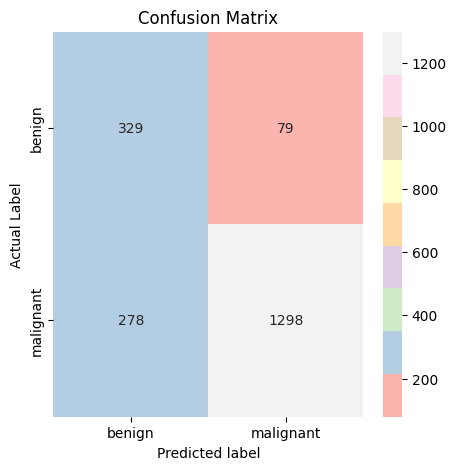

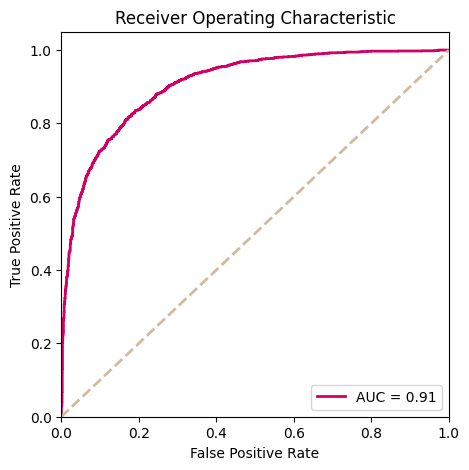

In [49]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './VGG16_Model'
model_save_dir = f'./{model_name}_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    # Train the model
    train_loss, train_acc = train(epoch, model, total_epochs, train_loader, criterion, optimizer, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save model every 5 epochs
    if epoch % 5 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break



Testing the model on the test dataset
Classification Report of Test:
              precision    recall  f1-score   support

      benign     0.6811    0.6667    0.6738      1938
   malignant     0.8695    0.8768    0.8731      4910

    accuracy                         0.8173      6848
   macro avg     0.7753    0.7717    0.7735      6848
weighted avg     0.8162    0.8173    0.8167      6848

Confusion Matrix:
[[1292  646]
 [ 605 4305]]


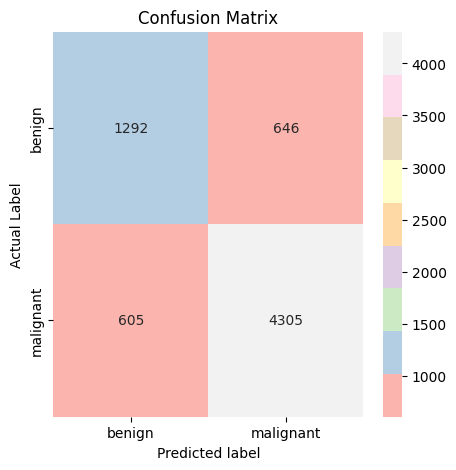

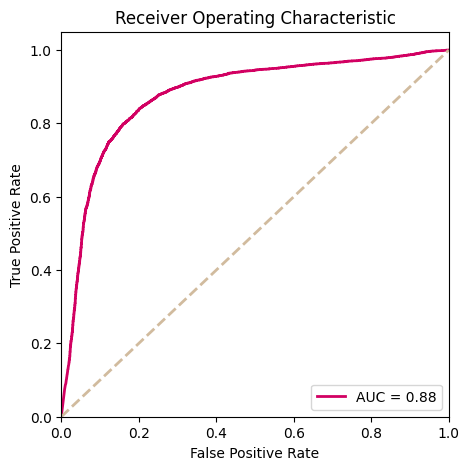

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8772

test set: Average loss: 0.8688, Accuracy: 5597/6851 (81.70%)



In [50]:
# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

## Resnet 18 model


In [51]:
class Resnet18(nn.Module):

    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()

        model_resnet18 = models.resnet18(pretrained=True)

        self.conv1 = model_resnet18.conv1  # convolutional function
        self.bn1 = model_resnet18.bn1  # batch normalization
        self.relu = model_resnet18.relu  # relu is your activation function.
        self.maxpool = model_resnet18.maxpool  # maxpool is basically taking the biggest value per sub-matrix

        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4  # these layers are use for deepening the layers in the architecture which will increase

        self.avgpool = model_resnet18.avgpool
        self._features = model_resnet18.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [52]:
model_name = 'resnet18'
model = Resnet18(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


### Training the Resnet18

Epoch 1/50: 100%|██████████| 639/639 [00:58<00:00, 10.83batch/s]

Train Epoch: 1 	Loss: 0.503939 	Accuracy: 63.92%


Confusion Matrix:
 [[400   8]
 [927 649]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.30      0.98      0.46       408
   malignant       0.99      0.41      0.58      1576

    accuracy                           0.53      1984
   macro avg       0.64      0.70      0.52      1984
weighted avg       0.85      0.53      0.56      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.5740

Validation set: Average loss: 0.8391, Accuracy: 1049/1989 (52.74%)

Best model saved with AUC 0.5740 at epoch 1 to ./resnet18_Model/resnet18_best.pth
Validation loss decreased (inf --> 0.839112). save model


Epoch 2/50: 100%|██████████| 639/639 [00:57<00:00, 11.20batch/s]

Train Epoch: 2 	Loss: 0.442962 	Accuracy: 69.80%


Confusion Matrix:
 [[ 366   42]
 [ 370 1206]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.50      0.90      0.64       408
   malignant       0.97      0.77      0.85      1576

    accuracy                           0.79      1984
   macro avg       0.73      0.83      0.75      1984
weighted avg       0.87      0.79      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8870

Validation set: Average loss: 0.4404, Accuracy: 1572/1989 (79.03%)

Best model saved with AUC 0.8870 at epoch 2 to ./resnet18_Model/resnet18_best.pth
Validation loss decreased (0.839112 --> 0.440440). save model


Epoch 3/50: 100%|██████████| 639/639 [00:56<00:00, 11.22batch/s]

Train Epoch: 3 	Loss: 0.422756 	Accuracy: 71.48%


Confusion Matrix:
 [[395  13]
 [740 836]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.35      0.97      0.51       408
   malignant       0.98      0.53      0.69      1576

    accuracy                           0.62      1984
   macro avg       0.67      0.75      0.60      1984
weighted avg       0.85      0.62      0.65      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.6904

Validation set: Average loss: 0.7828, Accuracy: 1231/1989 (61.89%)

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 639/639 [00:56<00:00, 11.36batch/s]

Train Epoch: 4 	Loss: 0.398284 	Accuracy: 73.45%


Confusion Matrix:
 [[ 381   27]
 [ 506 1070]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.43      0.93      0.59       408
   malignant       0.98      0.68      0.80      1576

    accuracy                           0.73      1984
   macro avg       0.70      0.81      0.69      1984
weighted avg       0.86      0.73      0.76      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8082

Validation set: Average loss: 0.5894, Accuracy: 1451/1989 (72.95%)

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 639/639 [00:57<00:00, 11.20batch/s]

Train Epoch: 5 	Loss: 0.383247 	Accuracy: 75.06%


Confusion Matrix:
 [[ 361   47]
 [ 364 1212]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.50      0.88      0.64       408
   malignant       0.96      0.77      0.86      1576

    accuracy                           0.79      1984
   macro avg       0.73      0.83      0.75      1984
weighted avg       0.87      0.79      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8868

Validation set: Average loss: 0.4301, Accuracy: 1573/1989 (79.08%)

Validation loss decreased (0.440440 --> 0.430110). save model


Epoch 6/50: 100%|██████████| 639/639 [00:57<00:00, 11.04batch/s]

Train Epoch: 6 	Loss: 0.371294 	Accuracy: 76.16%


Confusion Matrix:
 [[ 309   99]
 [ 202 1374]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.60      0.76      0.67       408
   malignant       0.93      0.87      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.77      0.81      0.79      1984
weighted avg       0.87      0.85      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9473

Validation set: Average loss: 0.2971, Accuracy: 1683/1989 (84.62%)

Best model saved with AUC 0.9473 at epoch 6 to ./resnet18_Model/resnet18_best.pth
Validation loss decreased (0.430110 --> 0.297072). save model


Epoch 7/50: 100%|██████████| 639/639 [00:56<00:00, 11.26batch/s]

Train Epoch: 7 	Loss: 0.354397 	Accuracy: 77.24%


Confusion Matrix:
 [[ 318   90]
 [ 307 1269]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.51      0.78      0.62       408
   malignant       0.93      0.81      0.86      1576

    accuracy                           0.80      1984
   macro avg       0.72      0.79      0.74      1984
weighted avg       0.85      0.80      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9008

Validation set: Average loss: 0.4249, Accuracy: 1587/1989 (79.79%)

EarlyStopping counter: 1 out of 20


Epoch 8/50: 100%|██████████| 639/639 [00:56<00:00, 11.23batch/s]

Train Epoch: 8 	Loss: 0.351769 	Accuracy: 77.45%


Confusion Matrix:
 [[ 343   65]
 [ 365 1211]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.48      0.84      0.61       408
   malignant       0.95      0.77      0.85      1576

    accuracy                           0.78      1984
   macro avg       0.72      0.80      0.73      1984
weighted avg       0.85      0.78      0.80      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8819

Validation set: Average loss: 0.5005, Accuracy: 1554/1989 (78.13%)

EarlyStopping counter: 2 out of 20


Epoch 9/50: 100%|██████████| 639/639 [00:56<00:00, 11.26batch/s]

Train Epoch: 9 	Loss: 0.350781 	Accuracy: 77.59%


Confusion Matrix:
 [[ 332   76]
 [ 283 1293]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.81      0.65       408
   malignant       0.94      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.74      0.82      0.76      1984
weighted avg       0.86      0.82      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9063

Validation set: Average loss: 0.4297, Accuracy: 1625/1989 (81.70%)

EarlyStopping counter: 3 out of 20


Epoch 10/50: 100%|██████████| 639/639 [00:56<00:00, 11.28batch/s]

Train Epoch: 10 	Loss: 0.329528 	Accuracy: 79.09%


Confusion Matrix:
 [[ 341   67]
 [ 260 1316]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.84      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9278

Validation set: Average loss: 0.3642, Accuracy: 1657/1989 (83.31%)

Model saved at epoch 10 to ./resnet18_Model/resnet18_epoch_10.pth
EarlyStopping counter: 4 out of 20


Epoch 11/50: 100%|██████████| 639/639 [00:56<00:00, 11.29batch/s]

Train Epoch: 11 	Loss: 0.329309 	Accuracy: 78.80%


Confusion Matrix:
 [[ 341   67]
 [ 245 1331]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.58      0.84      0.69       408
   malignant       0.95      0.84      0.90      1576

    accuracy                           0.84      1984
   macro avg       0.77      0.84      0.79      1984
weighted avg       0.88      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9232

Validation set: Average loss: 0.3809, Accuracy: 1672/1989 (84.06%)

EarlyStopping counter: 5 out of 20


Epoch 12/50: 100%|██████████| 639/639 [00:56<00:00, 11.26batch/s]

Train Epoch: 12 	Loss: 0.325673 	Accuracy: 79.52%


Confusion Matrix:
 [[ 355   53]
 [ 289 1287]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.87      0.67       408
   malignant       0.96      0.82      0.88      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.88      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9136

Validation set: Average loss: 0.4050, Accuracy: 1642/1989 (82.55%)

EarlyStopping counter: 6 out of 20


Epoch 13/50: 100%|██████████| 639/639 [00:56<00:00, 11.29batch/s]

Train Epoch: 13 	Loss: 0.314500 	Accuracy: 80.13%


Confusion Matrix:
 [[ 331   77]
 [ 266 1310]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.81      0.66       408
   malignant       0.94      0.83      0.88      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.82      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9235

Validation set: Average loss: 0.3784, Accuracy: 1641/1989 (82.50%)

EarlyStopping counter: 7 out of 20


Epoch 14/50: 100%|██████████| 639/639 [00:56<00:00, 11.28batch/s]

Train Epoch: 14 	Loss: 0.311027 	Accuracy: 80.61%


Confusion Matrix:
 [[ 346   62]
 [ 207 1369]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.63      0.85      0.72       408
   malignant       0.96      0.87      0.91      1576

    accuracy                           0.86      1984
   macro avg       0.79      0.86      0.82      1984
weighted avg       0.89      0.86      0.87      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9475

Validation set: Average loss: 0.3076, Accuracy: 1715/1989 (86.22%)

Best model saved with AUC 0.9475 at epoch 14 to ./resnet18_Model/resnet18_best.pth
EarlyStopping counter: 8 out of 20


Epoch 15/50: 100%|██████████| 639/639 [00:56<00:00, 11.26batch/s]

Train Epoch: 15 	Loss: 0.306188 	Accuracy: 80.72%


Confusion Matrix:
 [[ 342   66]
 [ 283 1293]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.84      0.66       408
   malignant       0.95      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.75      0.83      0.77      1984
weighted avg       0.87      0.82      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9194

Validation set: Average loss: 0.3919, Accuracy: 1635/1989 (82.20%)

EarlyStopping counter: 9 out of 20


Epoch 16/50: 100%|██████████| 639/639 [00:56<00:00, 11.39batch/s]

Train Epoch: 16 	Loss: 0.294287 	Accuracy: 81.33%


Confusion Matrix:
 [[ 301  107]
 [ 199 1377]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.60      0.74      0.66       408
   malignant       0.93      0.87      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.76      0.81      0.78      1984
weighted avg       0.86      0.85      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9288

Validation set: Average loss: 0.3971, Accuracy: 1678/1989 (84.36%)

EarlyStopping counter: 10 out of 20


Epoch 17/50: 100%|██████████| 639/639 [00:57<00:00, 11.16batch/s]

Train Epoch: 17 	Loss: 0.298649 	Accuracy: 81.46%


Confusion Matrix:
 [[ 332   76]
 [ 315 1261]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.51      0.81      0.63       408
   malignant       0.94      0.80      0.87      1576

    accuracy                           0.80      1984
   macro avg       0.73      0.81      0.75      1984
weighted avg       0.85      0.80      0.82      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8909

Validation set: Average loss: 0.4573, Accuracy: 1593/1989 (80.09%)

EarlyStopping counter: 11 out of 20


Epoch 18/50: 100%|██████████| 639/639 [00:57<00:00, 11.16batch/s]

Train Epoch: 18 	Loss: 0.291600 	Accuracy: 82.01%


Confusion Matrix:
 [[ 304  104]
 [ 330 1246]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.48      0.75      0.58       408
   malignant       0.92      0.79      0.85      1576

    accuracy                           0.78      1984
   macro avg       0.70      0.77      0.72      1984
weighted avg       0.83      0.78      0.80      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8650

Validation set: Average loss: 0.5379, Accuracy: 1550/1989 (77.93%)

EarlyStopping counter: 12 out of 20


Epoch 19/50: 100%|██████████| 639/639 [00:56<00:00, 11.26batch/s]

Train Epoch: 19 	Loss: 0.289542 	Accuracy: 81.77%


Confusion Matrix:
 [[ 331   77]
 [ 211 1365]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.61      0.81      0.70       408
   malignant       0.95      0.87      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.78      0.84      0.80      1984
weighted avg       0.88      0.85      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9424

Validation set: Average loss: 0.3279, Accuracy: 1696/1989 (85.27%)

EarlyStopping counter: 13 out of 20


Epoch 20/50: 100%|██████████| 639/639 [00:56<00:00, 11.29batch/s]

Train Epoch: 20 	Loss: 0.284418 	Accuracy: 82.32%


Confusion Matrix:
 [[ 322   86]
 [ 279 1297]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.79      0.64       408
   malignant       0.94      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.74      0.81      0.76      1984
weighted avg       0.86      0.82      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9095

Validation set: Average loss: 0.4295, Accuracy: 1619/1989 (81.40%)

Model saved at epoch 20 to ./resnet18_Model/resnet18_epoch_20.pth
EarlyStopping counter: 14 out of 20


Epoch 21/50: 100%|██████████| 639/639 [00:56<00:00, 11.25batch/s]

Train Epoch: 21 	Loss: 0.278309 	Accuracy: 82.69%


Confusion Matrix:
 [[ 354   54]
 [ 322 1254]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.52      0.87      0.65       408
   malignant       0.96      0.80      0.87      1576

    accuracy                           0.81      1984
   macro avg       0.74      0.83      0.76      1984
weighted avg       0.87      0.81      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8922

Validation set: Average loss: 0.4730, Accuracy: 1608/1989 (80.84%)

EarlyStopping counter: 15 out of 20


Epoch 22/50: 100%|██████████| 639/639 [00:56<00:00, 11.33batch/s]

Train Epoch: 22 	Loss: 0.274685 	Accuracy: 83.20%


Confusion Matrix:
 [[ 321   87]
 [ 241 1335]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.79      0.66       408
   malignant       0.94      0.85      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.82      0.78      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9158

Validation set: Average loss: 0.4427, Accuracy: 1656/1989 (83.26%)

EarlyStopping counter: 16 out of 20


Epoch 23/50: 100%|██████████| 639/639 [00:56<00:00, 11.32batch/s]

Train Epoch: 23 	Loss: 0.278628 	Accuracy: 83.01%


Confusion Matrix:
 [[ 303  105]
 [ 302 1274]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.50      0.74      0.60       408
   malignant       0.92      0.81      0.86      1576

    accuracy                           0.79      1984
   macro avg       0.71      0.78      0.73      1984
weighted avg       0.84      0.79      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8979

Validation set: Average loss: 0.4927, Accuracy: 1577/1989 (79.29%)

EarlyStopping counter: 17 out of 20


Epoch 24/50: 100%|██████████| 639/639 [00:55<00:00, 11.48batch/s]

Train Epoch: 24 	Loss: 0.270723 	Accuracy: 83.37%


Confusion Matrix:
 [[ 295  113]
 [ 228 1348]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.72      0.63       408
   malignant       0.92      0.86      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.74      0.79      0.76      1984
weighted avg       0.85      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9042

Validation set: Average loss: 0.4819, Accuracy: 1643/1989 (82.60%)

EarlyStopping counter: 18 out of 20


Epoch 25/50: 100%|██████████| 639/639 [00:55<00:00, 11.50batch/s]

Train Epoch: 25 	Loss: 0.266520 	Accuracy: 83.43%


Confusion Matrix:
 [[ 326   82]
 [ 255 1321]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.80      0.66       408
   malignant       0.94      0.84      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.82      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9207

Validation set: Average loss: 0.4274, Accuracy: 1647/1989 (82.81%)

EarlyStopping counter: 19 out of 20


Epoch 26/50: 100%|██████████| 639/639 [00:56<00:00, 11.39batch/s]

Train Epoch: 26 	Loss: 0.263936 	Accuracy: 83.76%


Confusion Matrix:
 [[ 303  105]
 [ 224 1352]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.74      0.65       408
   malignant       0.93      0.86      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.80      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9216

Validation set: Average loss: 0.5260, Accuracy: 1655/1989 (83.21%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 303  105]
 [ 224 1352]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.74      0.65       408
   malignant       0.93      0.86      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.80      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Spec

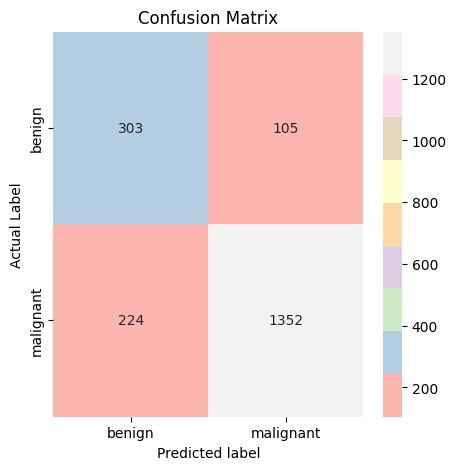

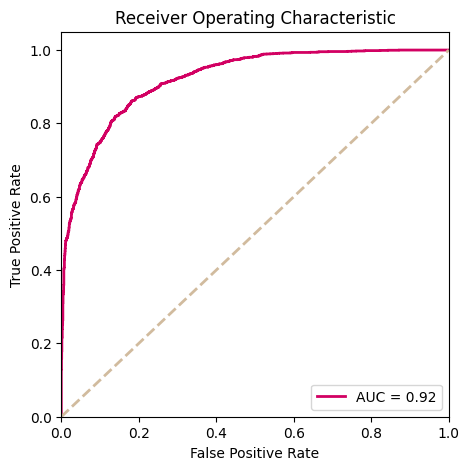

In [53]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './Resnet18_Model'
model_save_dir = f'./{model_name}_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    # Train the model
    train_loss, train_acc = train(epoch, model, total_epochs, train_loader, criterion, optimizer, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break



Testing the model on the test dataset
Classification Report of Test:
              precision    recall  f1-score   support

      benign     0.7272    0.5227    0.6082      1938
   malignant     0.8304    0.9226    0.8741      4910

    accuracy                         0.8094      6848
   macro avg     0.7788    0.7227    0.7412      6848
weighted avg     0.8012    0.8094    0.7989      6848

Confusion Matrix:
[[1013  925]
 [ 380 4530]]


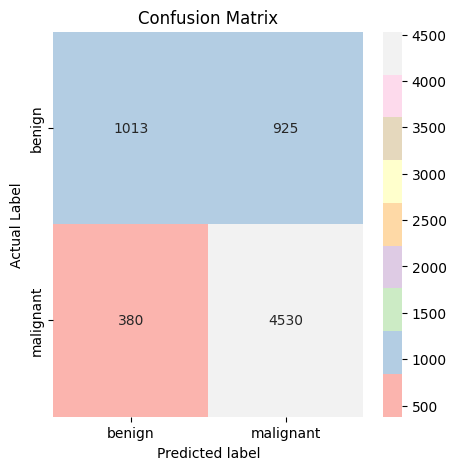

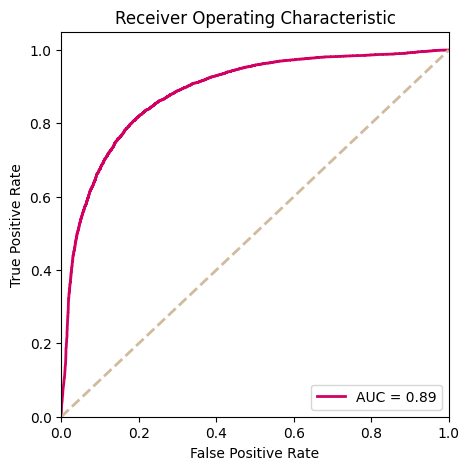

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8859

test set: Average loss: 0.8284, Accuracy: 5543/6851 (80.91%)



In [54]:
# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

## Resnet 50 model

In [62]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()

        model_resnet50 = models.resnet50(pretrained=True)

        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool

        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4

        self.avgpool = model_resnet50.avgpool
        self._features = model_resnet50.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [63]:
model_name = 'resnet50'
model = Resnet50(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

Epoch 1/50: 100%|██████████| 638/638 [01:42<00:00,  6.24batch/s]

Train Epoch: 1 	Loss: 0.486333 	Accuracy: 65.40%


Confusion Matrix:
 [[ 366   42]
 [ 457 1119]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.44      0.90      0.59       408
   malignant       0.96      0.71      0.82      1576

    accuracy                           0.75      1984
   macro avg       0.70      0.80      0.71      1984
weighted avg       0.86      0.75      0.77      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8431

Validation set: Average loss: 0.4972, Accuracy: 1485/1989 (74.66%)

Best model saved with AUC 0.8431 at epoch 1 to ./resnet50_Model/resnet50_best.pth
Validation loss decreased (inf --> 0.497227). save model


Epoch 2/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]


Train Epoch: 2 	Loss: 0.429869 	Accuracy: 70.78%
Confusion Matrix:
 [[397  11]
 [741 835]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.35      0.97      0.51       408
   malignant       0.99      0.53      0.69      1576

    accuracy                           0.62      1984
   macro avg       0.67      0.75      0.60      1984
weighted avg       0.86      0.62      0.65      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.6651

Validation set: Average loss: 0.8312, Accuracy: 1232/1989 (61.94%)

EarlyStopping counter: 1 out of 20


Epoch 3/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]

Train Epoch: 3 	Loss: 0.403865 	Accuracy: 73.24%


Confusion Matrix:
 [[ 379   29]
 [ 439 1137]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.46      0.93      0.62       408
   malignant       0.98      0.72      0.83      1576

    accuracy                           0.76      1984
   macro avg       0.72      0.83      0.72      1984
weighted avg       0.87      0.76      0.79      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8589

Validation set: Average loss: 0.4732, Accuracy: 1516/1989 (76.22%)

Best model saved with AUC 0.8589 at epoch 3 to ./resnet50_Model/resnet50_best.pth
Validation loss decreased (0.497227 --> 0.473226). save model


Epoch 4/50: 100%|██████████| 638/638 [01:42<00:00,  6.24batch/s]


Train Epoch: 4 	Loss: 0.387422 	Accuracy: 74.56%
Confusion Matrix:
 [[ 350   58]
 [ 412 1164]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.46      0.86      0.60       408
   malignant       0.95      0.74      0.83      1576

    accuracy                           0.76      1984
   macro avg       0.71      0.80      0.72      1984
weighted avg       0.85      0.76      0.78      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8660

Validation set: Average loss: 0.4618, Accuracy: 1514/1989 (76.12%)

Best model saved with AUC 0.8660 at epoch 4 to ./resnet50_Model/resnet50_best.pth
Validation loss decreased (0.473226 --> 0.461820). save model


Epoch 5/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]

Train Epoch: 5 	Loss: 0.378517 	Accuracy: 75.50%


Confusion Matrix:
 [[ 312   96]
 [ 189 1387]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.62      0.76      0.69       408
   malignant       0.94      0.88      0.91      1576

    accuracy                           0.86      1984
   macro avg       0.78      0.82      0.80      1984
weighted avg       0.87      0.86      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9514

Validation set: Average loss: 0.2864, Accuracy: 1699/1989 (85.42%)

Model saved at epoch 5 to ./resnet50_Model/resnet50_epoch_5.pth
Best model saved with AUC 0.9514 at epoch 5 to ./resnet50_Model/resnet50_best.pth
Validation loss decreased (0.461820 --> 0.286396). save model


Epoch 6/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 6 	Loss: 0.357433 	Accuracy: 76.83%
Confusion Matrix:
 [[ 349   59]
 [ 281 1295]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.86      0.67       408
   malignant       0.96      0.82      0.88      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9121

Validation set: Average loss: 0.4134, Accuracy: 1644/1989 (82.65%)

EarlyStopping counter: 1 out of 20


Epoch 7/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]


Train Epoch: 7 	Loss: 0.348780 	Accuracy: 77.90%
Confusion Matrix:
 [[ 326   82]
 [ 374 1202]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.47      0.80      0.59       408
   malignant       0.94      0.76      0.84      1576

    accuracy                           0.77      1984
   macro avg       0.70      0.78      0.71      1984
weighted avg       0.84      0.77      0.79      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8727

Validation set: Average loss: 0.4887, Accuracy: 1528/1989 (76.82%)

EarlyStopping counter: 2 out of 20


Epoch 8/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 8 	Loss: 0.334948 	Accuracy: 78.83%
Confusion Matrix:
 [[ 368   40]
 [ 290 1286]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.90      0.69       408
   malignant       0.97      0.82      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.86      0.79      1984
weighted avg       0.89      0.83      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9254

Validation set: Average loss: 0.3730, Accuracy: 1654/1989 (83.16%)

EarlyStopping counter: 3 out of 20


Epoch 9/50: 100%|██████████| 638/638 [01:42<00:00,  6.24batch/s]

Train Epoch: 9 	Loss: 0.329106 	Accuracy: 79.29%


Confusion Matrix:
 [[ 390   18]
 [ 494 1082]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.44      0.96      0.60       408
   malignant       0.98      0.69      0.81      1576

    accuracy                           0.74      1984
   macro avg       0.71      0.82      0.71      1984
weighted avg       0.87      0.74      0.77      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8364

Validation set: Average loss: 0.5970, Accuracy: 1472/1989 (74.01%)

EarlyStopping counter: 4 out of 20


Epoch 10/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]


Train Epoch: 10 	Loss: 0.321789 	Accuracy: 79.53%
Confusion Matrix:
 [[ 353   55]
 [ 390 1186]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.48      0.87      0.61       408
   malignant       0.96      0.75      0.84      1576

    accuracy                           0.78      1984
   macro avg       0.72      0.81      0.73      1984
weighted avg       0.86      0.78      0.80      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8715

Validation set: Average loss: 0.5078, Accuracy: 1539/1989 (77.38%)

Model saved at epoch 10 to ./resnet50_Model/resnet50_epoch_10.pth
EarlyStopping counter: 5 out of 20


Epoch 11/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 11 	Loss: 0.313298 	Accuracy: 80.07%
Confusion Matrix:
 [[ 345   63]
 [ 293 1283]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.85      0.66       408
   malignant       0.95      0.81      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.75      0.83      0.77      1984
weighted avg       0.87      0.82      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9223

Validation set: Average loss: 0.3862, Accuracy: 1628/1989 (81.85%)

EarlyStopping counter: 6 out of 20


Epoch 12/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]

Train Epoch: 12 	Loss: 0.301150 	Accuracy: 81.19%


Confusion Matrix:
 [[ 333   75]
 [ 225 1351]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.60      0.82      0.69       408
   malignant       0.95      0.86      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.77      0.84      0.79      1984
weighted avg       0.88      0.85      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9299

Validation set: Average loss: 0.3969, Accuracy: 1684/1989 (84.67%)

EarlyStopping counter: 7 out of 20


Epoch 13/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 13 	Loss: 0.299950 	Accuracy: 81.28%
Confusion Matrix:
 [[ 347   61]
 [ 314 1262]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.52      0.85      0.65       408
   malignant       0.95      0.80      0.87      1576

    accuracy                           0.81      1984
   macro avg       0.74      0.83      0.76      1984
weighted avg       0.87      0.81      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9042

Validation set: Average loss: 0.4605, Accuracy: 1609/1989 (80.89%)

EarlyStopping counter: 8 out of 20


Epoch 14/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 14 	Loss: 0.303516 	Accuracy: 80.78%
Confusion Matrix:
 [[ 338   70]
 [ 289 1287]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.54      0.83      0.65       408
   malignant       0.95      0.82      0.88      1576

    accuracy                           0.82      1984
   macro avg       0.74      0.82      0.77      1984
weighted avg       0.86      0.82      0.83      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9155

Validation set: Average loss: 0.4008, Accuracy: 1625/1989 (81.70%)

EarlyStopping counter: 9 out of 20


Epoch 15/50: 100%|██████████| 638/638 [01:42<00:00,  6.24batch/s]


Train Epoch: 15 	Loss: 0.291708 	Accuracy: 81.76%
Confusion Matrix:
 [[ 346   62]
 [ 341 1235]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.50      0.85      0.63       408
   malignant       0.95      0.78      0.86      1576

    accuracy                           0.80      1984
   macro avg       0.73      0.82      0.75      1984
weighted avg       0.86      0.80      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8877

Validation set: Average loss: 0.4880, Accuracy: 1581/1989 (79.49%)

Model saved at epoch 15 to ./resnet50_Model/resnet50_epoch_15.pth
EarlyStopping counter: 10 out of 20


Epoch 16/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]


Train Epoch: 16 	Loss: 0.286975 	Accuracy: 82.27%
Confusion Matrix:
 [[ 356   52]
 [ 248 1328]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.59      0.87      0.70       408
   malignant       0.96      0.84      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.78      0.86      0.80      1984
weighted avg       0.89      0.85      0.86      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9312

Validation set: Average loss: 0.3802, Accuracy: 1684/1989 (84.67%)

EarlyStopping counter: 11 out of 20


Epoch 17/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]

Train Epoch: 17 	Loss: 0.277259 	Accuracy: 82.48%


Confusion Matrix:
 [[ 327   81]
 [ 248 1328]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.80      0.67       408
   malignant       0.94      0.84      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.82      0.78      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9308

Validation set: Average loss: 0.3906, Accuracy: 1655/1989 (83.21%)

EarlyStopping counter: 12 out of 20


Epoch 18/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 18 	Loss: 0.271640 	Accuracy: 83.25%
Confusion Matrix:
 [[ 335   73]
 [ 328 1248]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.51      0.82      0.63       408
   malignant       0.94      0.79      0.86      1576

    accuracy                           0.80      1984
   macro avg       0.73      0.81      0.74      1984
weighted avg       0.85      0.80      0.81      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8822

Validation set: Average loss: 0.5555, Accuracy: 1583/1989 (79.59%)

EarlyStopping counter: 13 out of 20


Epoch 19/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]

Train Epoch: 19 	Loss: 0.275715 	Accuracy: 83.12%


Confusion Matrix:
 [[ 357   51]
 [ 231 1345]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.61      0.88      0.72       408
   malignant       0.96      0.85      0.91      1576

    accuracy                           0.86      1984
   macro avg       0.79      0.86      0.81      1984
weighted avg       0.89      0.86      0.87      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9451

Validation set: Average loss: 0.3289, Accuracy: 1702/1989 (85.57%)

EarlyStopping counter: 14 out of 20


Epoch 20/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 20 	Loss: 0.269407 	Accuracy: 83.44%
Confusion Matrix:
 [[ 340   68]
 [ 276 1300]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.55      0.83      0.66       408
   malignant       0.95      0.82      0.88      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.83      0.77      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9277

Validation set: Average loss: 0.3970, Accuracy: 1640/1989 (82.45%)

Model saved at epoch 20 to ./resnet50_Model/resnet50_epoch_20.pth
EarlyStopping counter: 15 out of 20


Epoch 21/50: 100%|██████████| 638/638 [01:41<00:00,  6.27batch/s]


Train Epoch: 21 	Loss: 0.266944 	Accuracy: 83.56%
Confusion Matrix:
 [[ 327   81]
 [ 168 1408]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.66      0.80      0.72       408
   malignant       0.95      0.89      0.92      1576

    accuracy                           0.87      1984
   macro avg       0.80      0.85      0.82      1984
weighted avg       0.89      0.87      0.88      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9548

Validation set: Average loss: 0.2867, Accuracy: 1735/1989 (87.23%)

Best model saved with AUC 0.9548 at epoch 21 to ./resnet50_Model/resnet50_best.pth
EarlyStopping counter: 16 out of 20


Epoch 22/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]


Train Epoch: 22 	Loss: 0.259887 	Accuracy: 83.87%
Confusion Matrix:
 [[ 368   40]
 [ 461 1115]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.44      0.90      0.59       408
   malignant       0.97      0.71      0.82      1576

    accuracy                           0.75      1984
   macro avg       0.70      0.80      0.71      1984
weighted avg       0.86      0.75      0.77      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8159

Validation set: Average loss: 1.0169, Accuracy: 1483/1989 (74.56%)

EarlyStopping counter: 17 out of 20


Epoch 23/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]

Train Epoch: 23 	Loss: 0.260787 	Accuracy: 84.00%


Confusion Matrix:
 [[ 325   83]
 [ 255 1321]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.80      0.66       408
   malignant       0.94      0.84      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.75      0.82      0.77      1984
weighted avg       0.86      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9184

Validation set: Average loss: 0.4731, Accuracy: 1646/1989 (82.76%)

EarlyStopping counter: 18 out of 20


Epoch 24/50: 100%|██████████| 638/638 [01:41<00:00,  6.26batch/s]

Train Epoch: 24 	Loss: 0.254129 	Accuracy: 84.11%


Confusion Matrix:
 [[ 329   79]
 [ 190 1386]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.63      0.81      0.71       408
   malignant       0.95      0.88      0.91      1576

    accuracy                           0.86      1984
   macro avg       0.79      0.84      0.81      1984
weighted avg       0.88      0.86      0.87      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9491

Validation set: Average loss: 0.3362, Accuracy: 1715/1989 (86.22%)

EarlyStopping counter: 19 out of 20


Epoch 25/50: 100%|██████████| 638/638 [01:42<00:00,  6.25batch/s]


Train Epoch: 25 	Loss: 0.253994 	Accuracy: 84.42%
Confusion Matrix:
 [[ 333   75]
 [ 253 1323]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.82      0.67       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.83      0.78      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9279

Validation set: Average loss: 0.4670, Accuracy: 1656/1989 (83.26%)

Model saved at epoch 25 to ./resnet50_Model/resnet50_epoch_25.pth
EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 333   75]
 [ 253 1323]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.82      0.67       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.83      198

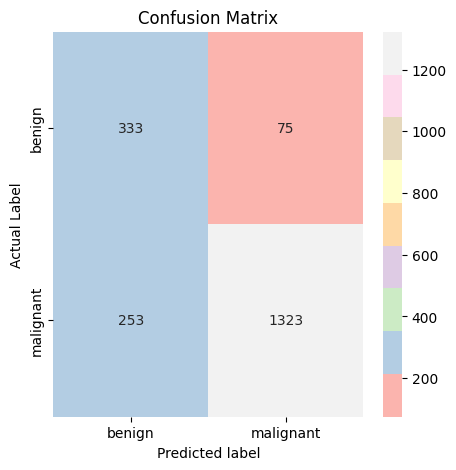

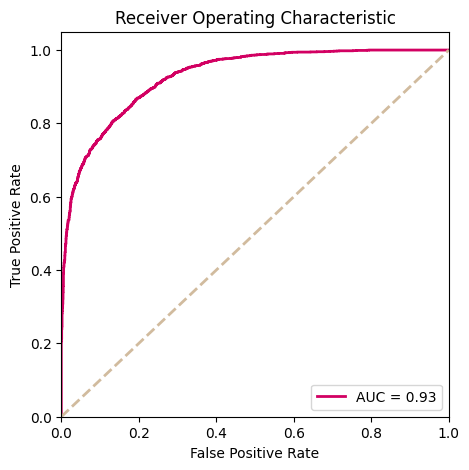

In [64]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './resnet50_Model'
model_save_dir = f'./{model_name}_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    # Train the model
    train_loss, train_acc = train(epoch, model, total_epochs, train_loader, criterion, optimizer, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save model every 5 epochs
    if epoch % 5 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break



Testing the model on the test dataset
Classification Report of Test:
              precision    recall  f1-score   support

      benign     0.6708    0.6078    0.6378      1938
   malignant     0.8507    0.8823    0.8662      4910

    accuracy                         0.8046      6848
   macro avg     0.7608    0.7451    0.7520      6848
weighted avg     0.7998    0.8046    0.8016      6848

Confusion Matrix:
[[1178  760]
 [ 578 4332]]


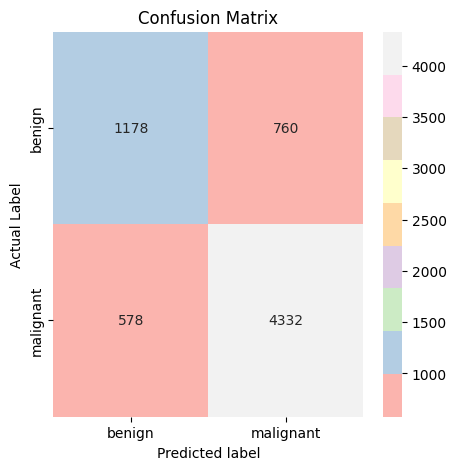

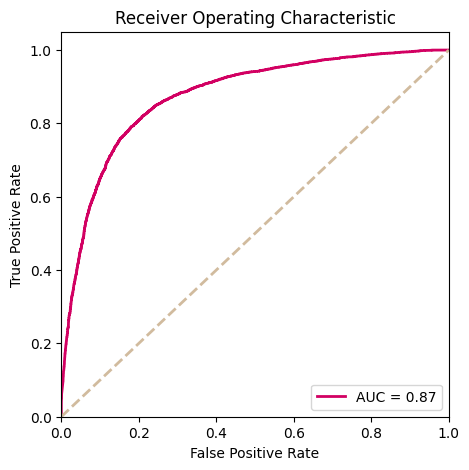

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8742

test set: Average loss: 0.8294, Accuracy: 5510/6851 (80.43%)



In [65]:
# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)